In [1]:
%matplotlib inline

In [2]:
from pprint import pprint
import matplotlib.pyplot as plt

# Introduction to Tethne: Working with data from the Web of Science

Now that we have the basics down, in this notebook we'll begin working with data from the [JSTOR Data-for-Research (DfR) portal](http://dfr.jstor.org/?&helpview=about_dfr).

The JSTOR DfR portal gives researchers access to
bibliographic data and N-grams for the entire JSTOR database.

Tethne can use DfR data to generate coauthorship networks, and to improve
metadata for Web of Science records. Tethne is also able to use
N-gram counts to add information to networks, and can interface with MALLET to perform LDA topic modeling.

## Methods in Digital & Computational Humanities

This notebook is part of a cluster of learning resources developed by the [Laubichler Lab](http://devo-evo.lab.asu.edu) and the [Digital Innovation Group](http://diging.asu.edu) at Arizona State University as part of an initiative for digital and computational humanities (d+cH). For more information, see our evolving online methods course at [https://diging.atlassian.net/wiki/display/DCH](https://diging.atlassian.net/wiki/display/DCH).

### Getting Help

Development of the Tethne project is led by [Erick Peirson](http://asu.academia.edu/erickpeirson). To get help, first check our [issue tracking system on GitHub](http://github.com/diging/tethne/issues). There, you can search for questions and problems reported by other users, or ask a question of your own. You can also reach Erick via e-mail at erick.peirson@asu.edu.

## Getting bibliographic data from JSTOR Data-for-Research

For the purpose of this tutorial, you can use the sample dataset from https://www.dropbox.com/s/q2jy87pmy9r6bsa/tethne_workshop_data.zip?dl=0.

Access the DfR portal at [http://dfr.jstor.org/](http://dfr.jstor.org/) If you don't already have an
account, you will need to [create a new account](http://dfr.jstor.org/accounts/register/).

After you've logged in, perform a search using whatever criteria you please.
When you have achieved the result that you desire, create a new dataset request.
Under the "Dataset Request" menu in the upper-right corner of the page, click
"Submit new request".

![](./images/wos/getting.5.png)

On the **Download Options** page, select your desired **Data Type**. If you do
not intend to make use of the contents of the papers themselves, then "Citations
Only" is sufficient. Otherwise, choose word counts, bigrams, etc.

**Output Format** should be set to **XML**.

Give your request a title, and set the maximum number of articles. *Note that
the maximum documents allowed per request is 1,000. Setting **Maximum Articles**
to a value less than the number of search results will yield a random sample of
your results.*

![](./images/wos/getting.6.png)

Your request should now appear in your list of **Data Requests**. When your
request is ready (hours to days later), you will receive an e-mail with a
download link. When downloading from the **Data Requests** list, be sure to use
the link in the **full dataset** column.

![](./images/wos/getting.7.png)

When your dataset download is complete, unzip it. The contents should look
something like those shown below.

![](./images/wos/getting.8.png)

``citations.XML`` contains bibliographic data in XML format. The ``bigrams``,
``trigrams``, ``wordcounts`` folders contain N-gram counts for each document.

If you were to open one of the XML files in the ``wordcounts`` folder, say, you would see some XML that looks like this:

```
<?xml version="1.0" encoding="UTF-8"?>
<article id="10.2307/4330482" >
    <wordcount weight="21" > of </wordcount>
    <wordcount weight="16" > the </wordcount>
    <wordcount weight="10" > university </wordcount>
    <wordcount weight="10" > a </wordcount>
    <wordcount weight="9" > s </wordcount>
    <wordcount weight="9" > d </wordcount>
    <wordcount weight="9" > harvard </wordcount>
    <wordcount weight="8" > m </wordcount>
    <wordcount weight="7" > and </wordcount>
    <wordcount weight="6" > u </wordcount>
    <wordcount weight="6" > press </wordcount>
    <wordcount weight="5" > cambridge </wordcount>
    <wordcount weight="5" > massachusetts </wordcount>
    <wordcount weight="5" > journal </wordcount>
    <wordcount weight="4" > by </wordcount>
    ...
    <wordcount weight="1" > stephen </wordcount>
    <wordcount weight="1" > liver </wordcount>
    <wordcount weight="1" > committee </wordcount>
    <wordcount weight="1" > school </wordcount>
    <wordcount weight="1" > lewontin </wordcount>
    <wordcount weight="1" > canguilhem </wordcount>
    <wordcount weight="1" > assistant </wordcount>
    <wordcount weight="1" > jay </wordcount>
    <wordcount weight="1" > state </wordcount>
    <wordcount weight="1" > morgan </wordcount>
    <wordcount weight="1" > advertising </wordcount>
    <wordcount weight="1" > animal </wordcount>
    <wordcount weight="1" > is </wordcount>
    <wordcount weight="1" > species </wordcount>
    <wordcount weight="1" > claude </wordcount>
    <wordcount weight="1" > review </wordcount>
    <wordcount weight="1" > hunt </wordcount>
    <wordcount weight="1" > founder </wordcount>
</article>
```

Each word is represented by a ``<wordcount></wordcount>`` tag. The ``"weight"`` attribute gives the number of times that the word occurs in the document, and the word itself is between the tags. We'll come back to this in just a moment.

## Parsing DfR datasets

Just as for WoS data, there is a module in ``tethne.readers`` for working with DfR data. We can import it with:

In [3]:
from tethne.readers import dfr

Once again, ``read()`` accepts a string containing a path to either a single DfR dataset, or a directory containing several. Here, "DfR dataset" refers to the folder containing the file "citations.xml", and the contents of that folder.

This will take considerably more time than loading a WoS dataset. The reason is that Tethne automatically detects and parses all of the wordcount data.

In [4]:
dfr_corpus = dfr.read('/Users/erickpeirson/Dropbox/HSS ThatCamp Workshop/sample_data/DfR')

### Combining DfR and WoS data

We can combine our datasets using the ``merge()`` function. First, we load our WoS data in a separate ``Corpus``:

In [5]:
from tethne.readers import wos
wos_corpus = wos.read('/Users/erickpeirson/Dropbox/HSS ThatCamp Workshop/sample_data/wos')

Both of these datasets are for the Journal of the History of Biology. But note that the WoS and DfR corpora have different numbers of ``Paper``s:

In [6]:
len(dfr_corpus), len(wos_corpus)

(1917, 1168)

Then import ``merge()`` from ``tethne.readers``:

In [7]:
from tethne.readers import merge

We then create a new ``Corpus`` by passing both ``Corpus`` objects to ``merge()``. If there is conflicting information in the two corpora, the first ``Corpus`` gets priority.

In [8]:
corpus = merge(dfr_corpus, wos_corpus)

``merge()`` has combined data where possible, and discarded any duplicates in the original datasets.

In [9]:
len(corpus)

1627

## FeatureSets

Our wordcount data are represented by a ``FeatureSet``. A ``FeatureSet`` is a description of how certain sets of elements are distributed across a ``Corpus``. This is kind of like an inversion of an index. For example, we might be interested in which words (elements) are found in which ``Paper``s. We can think of authors as a ``FeatureSet``, too.

All of the available ``FeatureSet``s are available in the ``features`` attribute (a dictionary) of our ``Corpus``. We can see the available ``FeatureSet``s by inspecting its:

In [10]:
corpus.features

{'authors': <tethne.classes.feature.FeatureSet at 0x124347810>,
 'citations': <tethne.classes.feature.FeatureSet at 0x124347890>,
 'wordcounts': <tethne.classes.feature.FeatureSet at 0x10611a3d0>}

Note that citations and authors are also ``FeatureSet``s. In fact, the majority of network-building functions in Tethne operate on ``FeatureSet``s -- including the ``coauthors()`` and ``bibliographic_coupling()`` functions that we used in the WoS notebook.

Each ``FeatureSet`` has several attributes. The ``features`` attribute contains the distribution data itself. These data themselves are ``(element, value)`` tuples. In this case, the elements are words, and the values are wordcounts.

In [11]:
corpus.features['wordcounts'].features.items()[0]    # Just show data for the first Paper.

(u'PORTER_CM_2005_JOURNAL_OF_THE_HISTORY_OF_BIOLOGY',
 [('essay', 1),
  ('all', 2),
  ('curate', 1),
  ('dynamic', 1),
  ('resistance', 1),
  ('alien', 1),
  ('contributions', 1),
  ('certainly', 1),
  ('william', 1),
  ('to', 12),
  ('excluded', 1),
  ('devotes', 1),
  ('summarizes', 1),
  ('garden', 1),
  ('sloppy', 1),
  ('waldo', 1),
  ('stiff', 1),
  ('did', 2),
  ('notes', 1),
  ('amerindian', 2),
  ('biological', 1),
  ('obsolete', 1),
  ('second', 1),
  ('theory', 1),
  ('even', 2),
  ('what', 1),
  ('burch', 1),
  ('contributed', 1),
  ('remain', 1),
  ('rafinesque', 15),
  ('suspect', 1),
  ('conduct', 1),
  ('publications', 1),
  ('loose', 1),
  ('superstition', 1),
  ('met', 1),
  ('separation', 1),
  ('alone', 1),
  ('consideration', 1),
  ('change', 1),
  ('extreme', 1),
  ('technical', 1),
  ('study', 1),
  ('moneygrabber', 1),
  ('suggestion', 1),
  ('opinion', 1),
  ('involves', 1),
  ('criticism', 1),
  ('family', 1),
  ('sicily', 1),
  ('biota', 1),
  ('from', 2),
  

The ``index`` contains our "vocabulary":

In [12]:
print 'There are %i words in the wordcounts featureset' % len(corpus.features['wordcounts'].index)

There are 134540 words in the wordcounts featureset


We can use the ``feature_distribution()`` method of our ``Corpus`` to look at the distribution of words over time. In the example below I used [MatPlotLib](http://matplotlib.org/) to visualize the distribution.

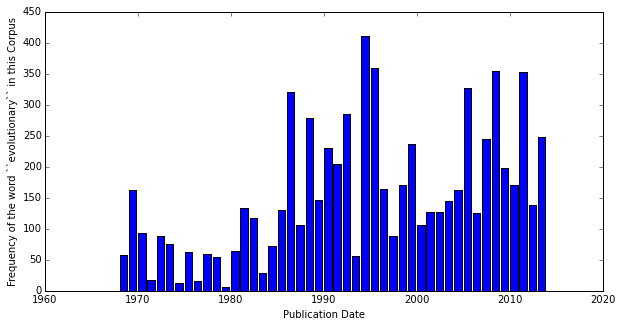

In [13]:
plt.figure(figsize=(10, 5))

plt.bar(*corpus.feature_distribution('wordcounts', 'evolutionary'))    # <-- The action.

plt.ylabel('Frequency of the word ``evolutionary`` in this Corpus')
plt.xlabel('Publication Date')
plt.show()

If we add the argument ``mode='documentCounts'``, we get the number of documents in which ``'evolutionary'`` occurs.

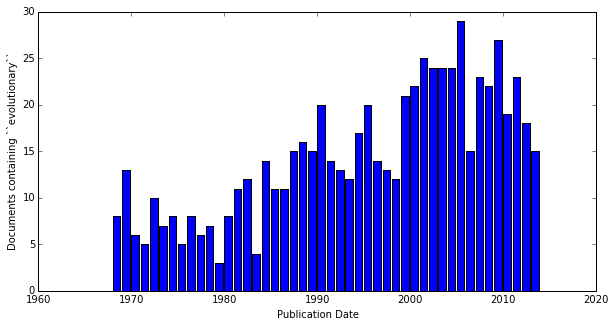

In [14]:
plt.figure(figsize=(10, 5))

plt.bar(*corpus.feature_distribution('wordcounts', 'evolutionary', mode='documentCounts'))    # <-- The action.

plt.ylabel('Documents containing ``evolutionary``')
plt.xlabel('Publication Date')
plt.show()

Note that we can look how documents themselves are distributed using the ``distribution()`` method.

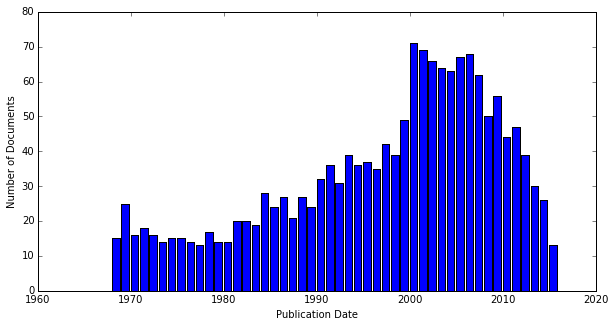

In [15]:
plt.figure(figsize=(10, 5))

plt.bar(*corpus.distribution())    # <-- The action.

plt.ylabel('Number of Documents')
plt.xlabel('Publication Date')
plt.show()

So, putting these together, we can normalize our ``feature_distribution()`` data to get a sense of the relative use of the word ``'evolution'``.

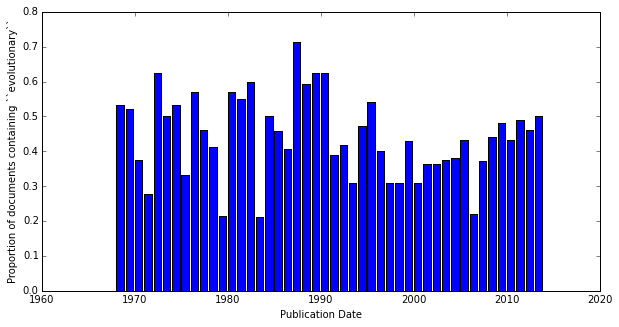

In [16]:
dates, N_evolution = corpus.feature_distribution('wordcounts', 'evolutionary', mode='documentCounts')
dates, N = corpus.distribution()
normalized_frequency = [f/N[i] for i, f in enumerate(N_evolution)]
plt.figure(figsize=(10, 5))

plt.bar(dates, normalized_frequency)    # <-- The action.

plt.ylabel('Proportion of documents containing ``evolutionary``')
plt.xlabel('Publication Date')
plt.show()

## Topic Modeling with DfR wordcounts

[Latent Dirichlet Allocation](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is a popular approach to discovering latent "topics" in large corpora. Many digital humanists use a software package called [MALLET](http://mallet.cs.umass.edu/) to fit LDA to text data. Tethne uses MALLET to fit LDA topic models.

Before we use LDA, however, we need to do some preprocessing. "Preprocessing" refers to anything that we do to filter or transform our ``FeatureSet`` prior to analysis. 

### Pre-processing

Two important preprocessing steps are:

    1. Removing "stopwords" -- common words like "the", "and", "but", "for", that don't yield much insight into the contents of documents.
    2. Removing words that are too common or too rare. These include typos or OCR artifacts.
    
We can do both of these by using the ``transform()`` method on our ``FeatureSet``.

First, we need a stoplist. [NLTK](http://www.nltk.org/) provides a great stoplist.

In [17]:
from nltk.corpus import stopwords
stoplist = stopwords.words()

We then need to define what elements to keep, and what elements to discard. We will use a function that will evaluate whether or not a word is in our stoplist. The function should take three arguments:

* ``f`` -- the feature itself (the word)
* ``v`` -- the number of instances of that feature in a specific document
* ``c`` -- the number of instances of that feature in the whole FeatureSet
* ``dc`` -- the number of documents that contain that feature

This function will be applied to each word in each document. If it returns ``0`` or ``None``, the word will be excluded. Otherwise, it should return a numeric value (in this case, the count for that document).

In addition to applying the stoplist, we'll also exclude any word that occurs in more than 500 of the documents and less than 3 documents, and is less than 4 characters in length.

In [18]:
def apply_stoplist(f, v, c, dc):
    if f in stoplist or dc > 500 or dc < 3 or len(f) < 4:
        return None    # Discard the element.
    return v

We apply the stoplist using the ``transform()`` method. ``FeatureSet``s are not modified in place; instead, a new ``FeatureSet`` is generated that reflects the specified changes. We'll call the new ``FeatureSet`` ``'wordcounts_filtered'``.

In [19]:
corpus.features['wordcounts_filtered'] = corpus.features['wordcounts'].transform(apply_stoplist)

There should be significantly fewer words in our new ``"wordcounts_filtered"`` ``FeatureSet``.

In [20]:
print 'There are %i words in the wordcounts featureset' % len(corpus.features['wordcounts'].index)
print 'There are %i words in the wordcounts_filtered featureset' % len(corpus.features['wordcounts_filtered'].index)

There are 134540 words in the wordcounts featureset
There are 41035 words in the wordcounts_filtered featureset


### The LDA topic model

Tethne provides a class called ``LDAModel``. You should be able to import it directly from the ``tethne`` package:

In [21]:
from tethne import LDAModel

Now we'll create a new ``LDAModel`` for our ``Corpus``. The ``featureset_name`` parameter tells the ``LDAModel`` which ``FeatureSet`` we want to use. We'll use our filtered wordcounts.

In [22]:
model = LDAModel(corpus, featureset_name='wordcounts_filtered')

Next we'll fit the model. We need to tell MALLET how many topics to fit (the hyperparameter ``Z``), and how many iterations (``max_iter``) to perform. This step may take a little while, depending on the size of your corpus.

In [23]:
model.fit(Z=50, max_iter=500)

You can inspect the inferred topics using the model's ``print_topics()`` method. By default, this will print the top ten words for each topic.

In [24]:
model.print_topics()

Topic	Top 10 words
0  	weismann heredity variation inheritance characters vries hereditary johannsen variations transmission
1  	henderson blood oxygen chemistry vinogradskii chemical hemoglobin carbon liebig barcroft
2  	family father language romanes white letters autobiography children carpenter mental
3  	female women sexual male behavior rats hormones woman control birth
4  	cells immunology cell antibodies jerne immune antibody metchnikoff ehrlich immunity
5  	practices discipline cultural broader debates emerged fields diverse disciplines project
6  	ecology environmental ecological fish conservation management ecologists salmon wildlife fisheries
7  	disease cancer health rous diseases clinical illness patients symptoms beaumont
8  	harvey blood civet renaissance fernel fish spirits medieval circulation seventeenth
9  	behavior lorenz agassiz bees instincts girard instinct psychology learning thorpe
10 	zoology museum brooks hopkins morphology johns marine alexander teaching mu

We can also look at the representation of a topic over time using the ``topic_over_time()`` method. In the example below we'll print the first five of the topics on the same plot.

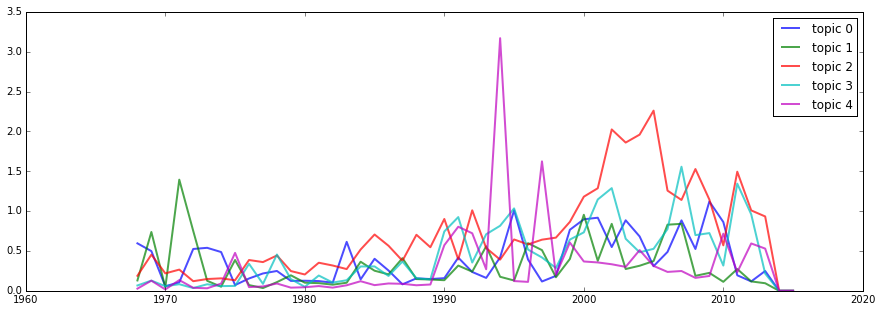

In [28]:
plt.figure(figsize=(15, 5))
for k in xrange(5):    # Generates numbers k in [0, 4].
    x, y = model.topic_over_time(k)    # Gets topic number k.
    plt.plot(x, y, label='topic {0}'.format(k), lw=2, alpha=0.7)
plt.legend(loc='best')
plt.show()    

## Generating networks from topic models

The ``features`` module in the ``tethne.networks`` subpackage contains some useful methods for visualizing topic models as networks. You can import it just like the ``authors`` or ``papers`` modules.

In [29]:
from tethne.networks import topics

The ``terms`` function generates a network of words connected on the basis of shared affinity with a topic. If two words *i* and *j* are both associated with a topic *z* with $\Phi(i|z) >= 0.01$ and $\Phi(j|z) >= 0.01$, then an edge is drawn between them. 

In [30]:
termGraph = topics.terms(model, threshold=0.01)

In [35]:
termGraph.order(), termGraph.size()

(280, 1105)

In [36]:
termGraph.name = ''

In [37]:
from tethne.writers.graph import to_graphml
to_graphml(termGraph, '/Users/erickpeirson/Desktop/topic_terms.graphml')

![](images/lda2.png)

In [32]:
topicCoupling = topics.topic_coupling(model, threshold=0.2)

In [33]:
print '%i nodes and %i edges' % (topicCoupling.order(), topicCoupling.size())

1059 nodes and 17707 edges


In [38]:
to_graphml(topicCoupling, '/Users/erickpeirson/Desktop/lda_topicCoupling.graphml')

![](images/lda_topicCoupling.png)